<a href="https://colab.research.google.com/github/Bowman1410/ASL_Alphabet_Recognition/blob/main/SignLanguage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"iainbowman1410","key":"7207d429148fa3ebdc25490fb974bc30"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!pip install -q kaggle

In [6]:
!kaggle datasets download -d grassknoted/asl-alphabet

100% 1.02G/1.03G [00:35<00:00, 33.1MB/s]
100% 1.03G/1.03G [00:35<00:00, 30.8MB/s]


In [7]:
!unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

In [8]:
!pip install split-folders

In [9]:
import os
import cv2
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import splitfolders
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

In [10]:
train_src = r"/content/asl_alphabet_train/asl_alphabet_train"


splitfolders.ratio(train_src, output="datasets/asl_alphabet",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 87000 files [00:23, 3627.22 files/s]


In [11]:
train_dir = 'datasets/asl_alphabet/train'
val_dir = 'datasets/asl_alphabet/val'
test_dir = r"/content/asl_alphabet_train/asl_alphabet_train"

In [30]:
batch_size = 32
target_size = (32, 32)

In [31]:
# Data Augmentation and Normalization for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Normalization for test data
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=False
)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
Found 87000 images belonging to 29 classes.


In [32]:
labels = list(train_generator.class_indices.keys())
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [33]:
labels = list(test_generator.class_indices.keys())
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [34]:
import os
import cv2
import matplotlib.pyplot as plt
TRAIN_PATH = train_dir
def sample_images(labels):
    # Create Subplots
    y_size = 12
    if(len(labels)<10):
        y_size = y_size * len(labels) / 10
    fig, axs = plt.subplots(len(labels), 9, figsize=(y_size, 13))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_path = os.path.join(TRAIN_PATH, label)
        list_files = os.listdir(label_path)

        for j in range(8):
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
            axs[i, j+1].imshow(img_label)
            axs[i, j+1].axis("off")

    # Title
    plt.suptitle("Sample Images in ASL Alphabet Dataset", x=0.55, y=0.92)

    # Show
    plt.show()

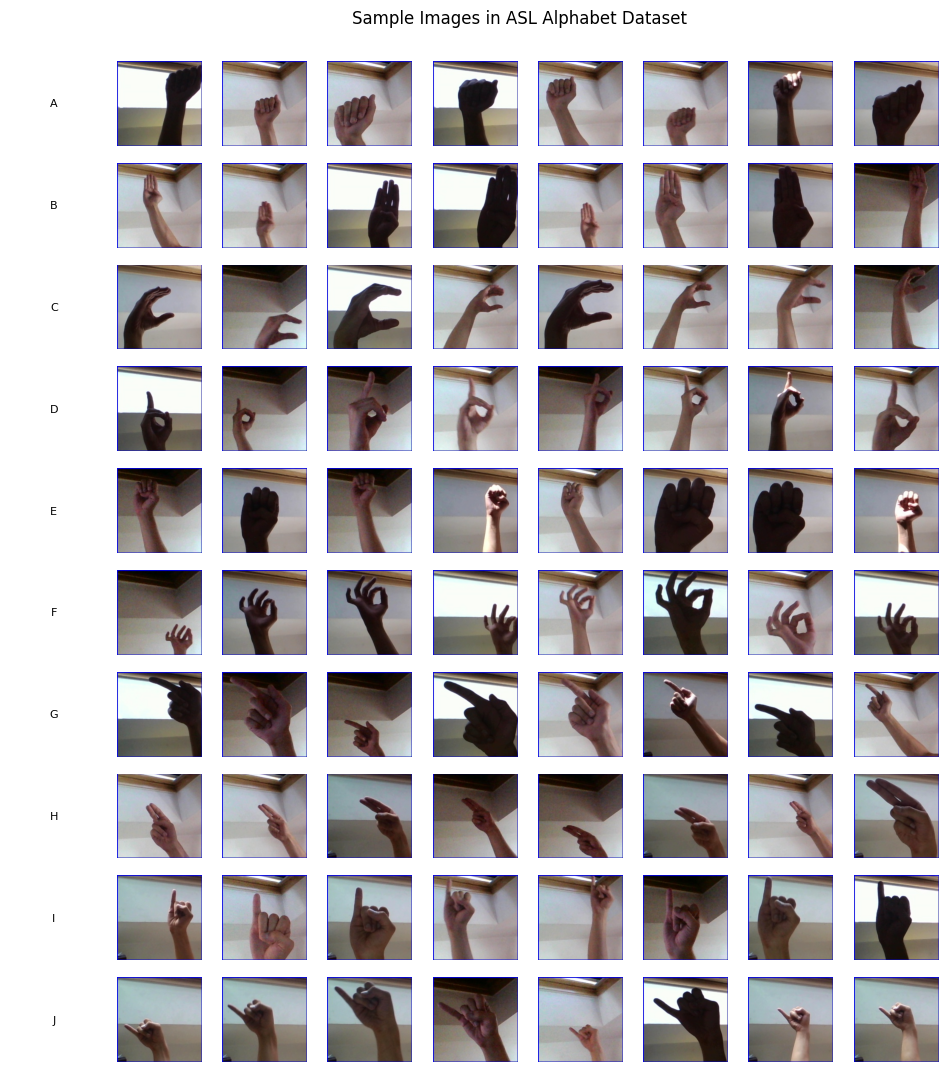

In [35]:
sample_images(labels[:10])

In [44]:
# Model Architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')
])

In [45]:
# Optimizer and Learning Rate Scheduler
epochs = 25
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=train_generator.samples // batch_size * epochs)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [46]:
# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [47]:
# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)

In [48]:
# Train the model
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    callbacks=[early_stopping])

Epoch 1/25
2175/2175 [==============================] - 230s 105ms/step - loss: 2.7728 - accuracy: 0.2561 - val_loss: 2.0398 - val_accuracy: 0.4327
Epoch 2/25
2175/2175 [==============================] - 215s 99ms/step - loss: 1.8575 - accuracy: 0.4775 - val_loss: 2.5355 - val_accuracy: 0.3963
Epoch 3/25
2175/2175 [==============================] - 218s 100ms/step - loss: 1.5346 - accuracy: 0.5735 - val_loss: 1.5800 - val_accuracy: 0.5699
Epoch 4/25
2175/2175 [==============================] - 218s 100ms/step - loss: 1.3688 - accuracy: 0.6235 - val_loss: 2.3698 - val_accuracy: 0.4914
Epoch 5/25
2175/2175 [==============================] - 213s 98ms/step - loss: 1.2664 - accuracy: 0.6562 - val_loss: 1.0661 - val_accuracy: 0.7248
Epoch 6/25
2175/2175 [==============================] - 212s 98ms/step - loss: 1.1814 - accuracy: 0.6828 - val_loss: 0.8997 - val_accuracy: 0.7818
Epoch 7/25
2175/2175 [==============================] - 208s 95ms/step - loss: 1.1116 - accuracy: 0.7023 - val_loss

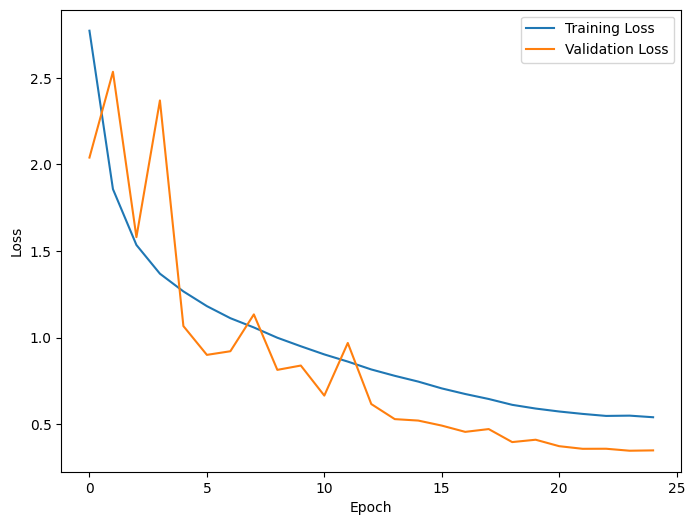

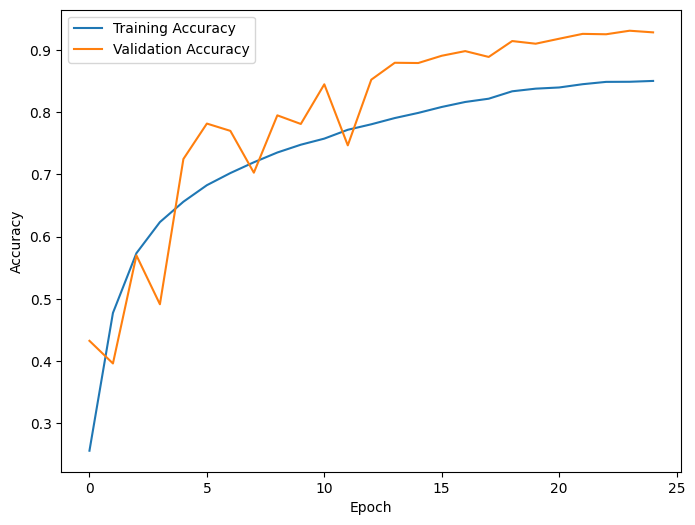

In [49]:
import matplotlib.pyplot as plt

# Get the training and validation loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [50]:
scores = model.evaluate(test_generator)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

2719/2719 [==============================] - 140s 51ms/step - loss: 0.2052 - accuracy: 0.9691
Test loss: 0.20521223545074463
Test accuracy: 0.9691264629364014


In [ ]:
#import tensorflow as tf
#converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [ ]:
#tflite_model = converter.convert()

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#saved_model_dir = '/content/drive/My Drive/models'
#model = tf.keras.models.load_model(saved_model_dir)

In [ ]:
#import tensorflow as tf
#converter = tf.lite.TFLiteConverter.from_keras_model(model)
#tflite_model = converter.convert()

In [ ]:
#output_dir = '/content/drive/My Drive/models_tflite'
#output_file = 'converted_model.tflite'
#output_path = f"{output_dir}/{output_file}"

# Save the converted model to the specified directory
#with open(output_path, 'wb') as f:
#    f.write(tflite_model)

In [51]:
!git clone https://github.com/Bowman1410/ASL_Alphabet_Recognition.git

Cloning into 'ASL_Alphabet_Recognition'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), done.
